# Clustering with sklearn

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense or another) to each other than to those in other groups (clusters). It is a main task of exploratory data mining, and a common technique for statistical data analysis, used in many fields, including machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics.
[Wikipedia: https://en.wikipedia.org/wiki/Cluster_analysis]

A nice introduction to clustering in Python, and why it is a good option for EDA (exploratory data analysis) can be found here:  http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
This blog shows why python is efficient for this task, gives a general overview of the different algorithm.

The next step is to see what algorithms are implemented in the sklearn Python module, the strengths and drawbacks of each of them, through examples: http://scikit-learn.org/stable/modules/clustering.html#dbscan

In [7]:
import sys,os
from astropy.io import ascii,fits
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
%matplotlib inline
import numpy as np
from datetime import timedelta #datetime
from scipy.interpolate import interp1d
import seaborn as sns
import numpy.ma as ma
from statsmodels import robust

from time import time
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

import pandas as pd
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier

path_root = '/Users/jmilli/Documents/atmospheric_parameters/SCIDAR'

/Users/jmilli/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


The example used in this python coffee is based on SCIDAR data. The SCIDAR is a turbulence profiler in Paranal in operations since mid-2016. 
I import here the turbulence profiles of the few available runs since the start of the operations (sparse data set), stored in the form of a csv file. For that I use the pandas module.

In [8]:
Cn2_pd = pd.read_csv(os.path.join(path_root,'Cn2_interpolated.csv'), 
                       parse_dates=[0],dayfirst=True, index_col=0)#, sep=' ', encoding='latin1'

Let's have a look at the table:

In [11]:
Cn2_pd.head()

00000.00m     00262.21m     00524.41m     00786.62m  \
﻿Date                                                                         
2016-04-29 23:37:19  4.390000e-16  0.000000e+00  3.980000e-18  1.200000e-17   
2016-04-29 23:38:44  7.710000e-16  0.000000e+00  1.710000e-18  9.630000e-18   
2016-04-29 23:40:08  6.800000e-16  0.000000e+00  2.640000e-18  8.300000e-18   
2016-04-29 23:42:11  3.500000e-16  2.180000e-16  0.000000e+00  4.200000e-18   
2016-04-29 23:43:41  2.630000e-16  8.660000e-18  1.830000e-17  1.190000e-17   

                        01048.83m     01311.03m     01573.24m     01835.44m  \
﻿Date                                                                         
2016-04-29 23:37:19  4.130000e-18  1.070000e-17  1.050000e-17  1.030000e-17   
2016-04-29 23:38:44  9.540000e-18  4.370000e-18  1.180000e-17  5.970000e-18   
2016-04-29 23:40:08  3.140000e-18  9.290000e-18  1.120000e-17  9.110000e-18   
2016-04-29 23:42:11  1.560000e-17  1.500000e-17  7.910000e-18  6.380000e-18   
2016-04-29 23:43:41  5.420000e-18  1.220000e-17  4.710000e-18  5.020000e-18   

                        02097.65m     02359.86m    ...      27793.88m  \
﻿Date                                              ...                  
2016-04-29 23:37:19  1.500000e-17  1.550000e-17    ...            0.0   
2016-04-29 23:38:44  1.200000e-17  1.740000e-17    ...            0.0   
2016-04-29 23:40:08  1.090000e-17  1.580000e-17    ...            0.0   
2016-04-29 23:42:11  1.160000e-17  1.490000e-17    ...            0.0   
2016-04-29 23:43:41  8.140000e-18  8.210000e-18    ...            0.0   

                     28056.08m  28318.29m  28580.50m  28842.70m  29104.91m  \
﻿Date                                                                        
2016-04-29 23:37:19        0.0        0.0        0.0        0.0        0.0   
2016-04-29 23:38:44        0.0        0.0        0.0        0.0        0.0   
2016-04-29 23:40:08        0.0        0.0        0.0        0.0        0.0   
2016-04-29 23:42:11        0.0        0.0        0.0        0.0        0.0   
2016-04-29 23:43:41        0.0        0.0        0.0        0.0        0.0   

                     29367.12m  29629.32m  29891.53m  30153.74m  
﻿Date                                                            
2016-04-29 23:37:19        0.0        0.0        0.0          0  
2016-04-29 23:38:44        0.0        0.0        0.0          0  
2016-04-29 23:40:08        0.0        0.0        0.0          0  
2016-04-29 23:42:11        0.0        0.0        0.0          0  
2016-04-29 23:43:41        0.0        0.0        0.0          0  

[5 rows x 116 columns]

In [13]:
Cn2_pd.shape

(2878, 116)

We have 2878 turbulence profiles, and for each profile we have the strength of the turbulence (expressed in the form of a Cn^2 in m^1/2) for 116 altitude layers

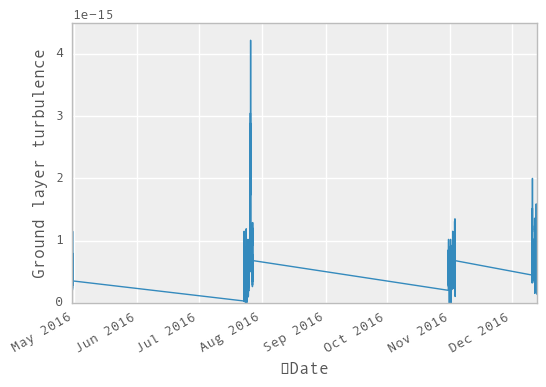

In [15]:
Cn2_pd['00000.00m'].plot()
plt.ylabel('Ground layer turbulence')

The data are not evenly spread in time, we have 4 SCIDAR runs, and for each runs, a few hundred of profiles were measured over a few nights. 

The column label is given as a string representing the altitude in m. I convert that string label in an array.

In [16]:
altitude = np.asarray([float(str_alt[0:-1]) for str_alt in Cn2_pd.columns])
print(altitude)
print(len(altitude))

[     0.      262.21    524.41    786.62   1048.83   1311.03   1573.24
   1835.44   2097.65   2359.86   2622.06   2884.27   3146.48   3408.68
   3670.89   3933.1    4195.3    4457.51   4719.72   4981.92   5244.13
   5506.33   5768.54   6030.75   6292.95   6555.16   6817.37   7079.57
   7341.78   7603.99   7866.19   8128.4    8390.6    8652.81   8915.02
   9177.22   9439.43   9701.64   9963.84  10226.05  10488.26  10750.46
  11012.67  11274.88  11537.08  11799.29  12061.49  12323.7   12585.91
  12848.11  13110.32  13372.53  13634.73  13896.94  14159.15  14421.35
  14683.56  14945.76  15207.97  15470.18  15732.38  15994.59  16256.8
  16519.    16781.21  17043.42  17305.62  17567.83  17830.03  18092.24
  18354.45  18616.65  18878.86  19141.07  19403.27  19665.48  19927.69
  20189.89  20452.1   20714.31  20976.51  21238.72  21500.92  21763.13
  22025.34  22287.54  22549.75  22811.96  23074.16  23336.37  23598.58
  23860.78  24122.99  24385.19  24647.4   24909.61  25171.81  25434.02
  25696

Let's have a look at some profiles

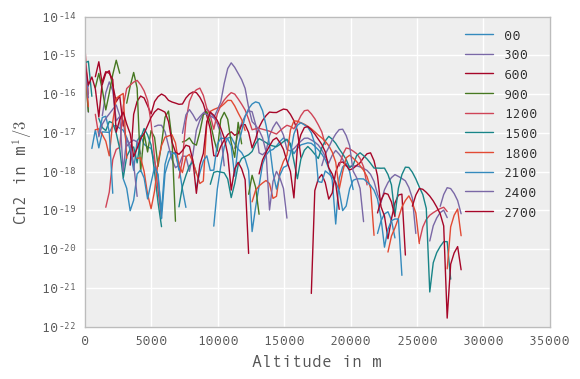

In [17]:
for i in range(0,2870,300):
    plt.semilogy(altitude,Cn2_pd.iloc[i, 0:116],label='{0:02d}'.format(i))
plt.legend(frameon=False)
plt.xlabel('Altitude in m')
plt.ylabel('Cn2 in m$^1/3$')

# First technique: Principal Component Analysis

In [18]:
ncomp = 10
pca = PCA(n_components=ncomp)
PC = pca.fit_transform(Cn2_pd) 

Sum of the explained variance for the first 2 PC: 58.1


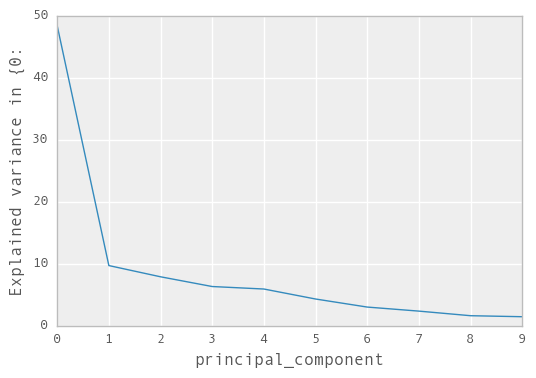

In [95]:
PC= np.asarray(PC)

plt.plot(pca.explained_variance_ratio_*100) 
plt.ylabel('Explained variance in {0:')
plt.xlabel('principal_component')
plt.savefig(os.path.join(path_root,'explained_variance.pdf'))

#print(pca.explained_variance_ratio_) 
nb_pc = 2
print('Sum of the explained variance for the first {0:d} PC: {1:3.1f}'.format(nb_pc,100*np.sum(pca.explained_variance_ratio_[0:nb_pc])))
#print(pca.explained_variance_) 

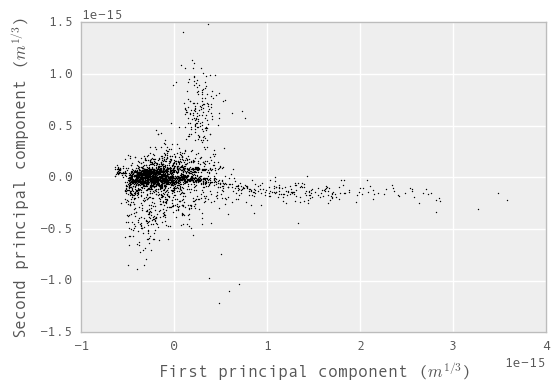

In [96]:
plt.plot(PC[:,0],PC[:,1], 'k.', markersize=2)
plt.xlabel('First principal component ($m^{1/3}$)')
plt.ylabel('Second principal component ($m^{1/3}$)')


## OK but  at this point we have reduced the dimensionality of our problem, but we have not clustered the data yet

Now let's use the K-Means clustering technique. 
Say we want to group these data in 5 clusters. Applying the K-means algorithm takes 3 lines of code

In [23]:
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=5)
kmeans.fit(PC[:,0:2])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=5,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

The rest is purely for plotting purposes and you can skip it

In [24]:
x_min, x_max = PC[:, 0].min() , PC[:, 0].max() 
y_min, y_max = PC[:, 1].min() , PC[:, 1].max()
dx = (x_max-x_min)/100
print(dx)

4.21233117256e-17


Above, I just find the size of my cells in the PC1 vs PC2 space shown above

In [25]:
h = 4e-17     # point in the mesh [x_min, x_max]x[y_min, y_max].
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [26]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

([], <a list of 0 Text yticklabel objects>)

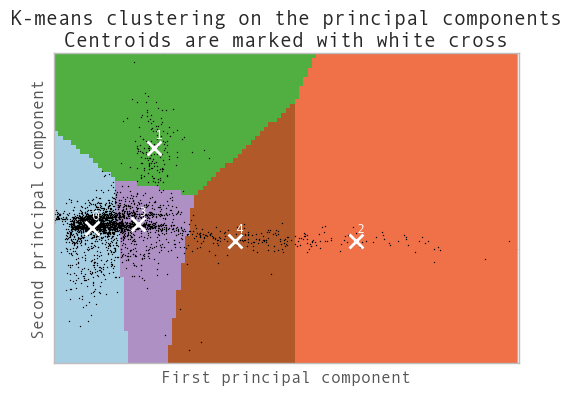

In [27]:
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(PC[:, 0], PC[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=100, linewidths=2,
            color='w', zorder=10)
plt.title('K-means clustering on the principal components\n'
          'Centroids are marked with white cross')
for i in range(n_clusters):
    plt.text(centroids[i, 0], centroids[i, 1]+2*h,'{0:d}'.format(i),color='w')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.xticks(())
plt.yticks(())

The white dots are the center points of each cluster. 
Let's plot the mean profile of each cluster now

In [28]:
mean_profile = np.ndarray((n_clusters,Cn2_pd.shape[1]))
freq = np.ndarray((n_clusters))
for i in range(n_clusters):
    id_cluster = kmeans.labels_ == i
    freq[i] = np.sum(id_cluster)*1./Cn2_pd.shape[0]
    mean_profile[i,:] = np.mean(Cn2_pd.iloc[id_cluster,:],axis=0)

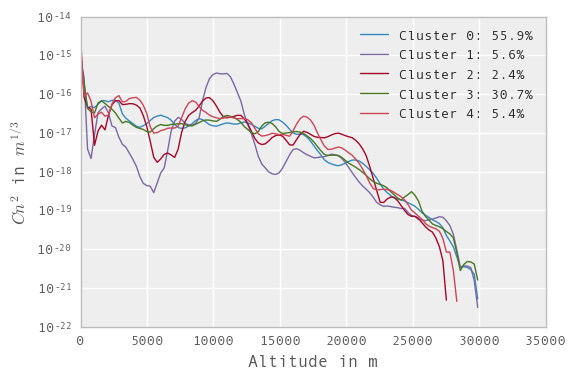

In [29]:
for i in range(n_clusters):
    plt.semilogy(altitude,mean_profile[i,:],label='Cluster {0:d}: {1:2.1f}%'.format(i,freq[i]*100))
plt.legend(frameon=False)
plt.xlabel('Altitude in m')
plt.ylabel('$Cn^2$ in $m^{1/3}$')

## Apply K-means directly

Here we have applied K-Means after a PCA on a 2D space. We could also apply directly to our 116D space

In [30]:
n_samples, n_features = Cn2_pd.shape
n_clusters = 5

In [31]:
kmeans2 = KMeans(init='k-means++', n_clusters=n_clusters, n_init=5)
kmeans2.fit(Cn2_pd)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=5,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

As you see this is very fast. However we can't represent visually those clusters now.

In [32]:
mean_profile_2 = np.ndarray((n_clusters,Cn2_pd.shape[1]))
freq_2 = np.ndarray((n_clusters))
for i in range(n_clusters):
    id_cluster = kmeans2.labels_ == i
    freq_2[i] = np.sum(id_cluster)*1./Cn2_pd.shape[0]
    mean_profile_2[i,:] = np.mean(Cn2_pd.iloc[id_cluster,:],axis=0)

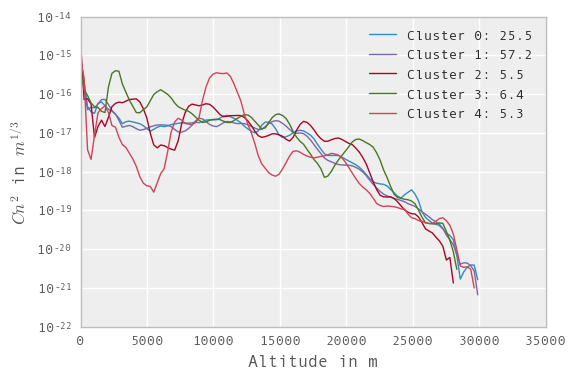

In [33]:
for i in range(n_clusters):
    plt.semilogy(altitude,mean_profile_2[i,:],label='Cluster {0:d}: {1:2.1f}'.format(i,freq_2[i]*100))
plt.legend(frameon=False)
plt.xlabel('Altitude in m')
plt.ylabel('$Cn^2$ in $m^{1/3}$')

## Affinity propagation

This is another technique based on graphs. On strength is that you don't define the number of clusters but the algorithm define it automatically depending on the data.

In [34]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation().fit(PC[:,0:2])
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

In [35]:
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: {0:d}'.format(n_clusters_))

Estimated number of clusters: 408


## DBSCan

In [36]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.1, min_samples=10).fit(PC[:,0:2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 1


/Users/jmilli/anaconda/lib/python3.5/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


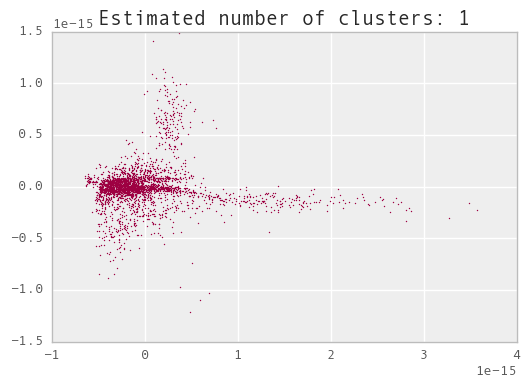

In [37]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
data_db = PC[:,0:2]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = data_db[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=1)

    xy = data_db[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=10)

plt.title('Estimated number of clusters: %d' % n_clusters_)